# Catboost Modelling

In this notebook, a final sales forecasting model based on the CatBoost algorithm is created. More information can be found here: https://catboost.ai/

Just as the Random Forest model, the final model is also a tree-based model. These types of algorithms lend themselves well to predicting target features that are not normally distributed, as is the case with sales here. Moreover, CatBoost is specifically tailored to datasets with many categorical variables. With the expception of weather and lag variables, this dataset mainly contains categorical features, including dummy variables.

Given the flexibility of CatBoost, no additional preprocessing is necessary. It can handle object (categorical) variables, missing values and responds well to non-normally distributed target variables.

In [1]:
pip install catboost sktime optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.patches import Patch
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import sktime

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
import catboost as cb
import optuna

In [3]:
#sktime libraries

from sktime.forecasting.compose import make_reduction, ForecastingPipeline, TransformedTargetForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows, plot_series
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.func_transform import FunctionTransformer as ft

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# for google colab
!unrar x drive/MyDrive/sweet-spot-donut-sales-forecasting.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from drive/MyDrive/sweet-spot-donut-sales-forecasting.rar

Extracting  functions_model.py                                             0%  OK 
Extracting  functions_vis.py                                               0%  OK 
Extracting  train_df.csv                                                  99%  OK 
Extracting  test_df.csv                                                  100%  OK 
All OK


In [6]:
! jupyter nbextension enable widgetsnbextension --py

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [17]:
%run functions_model.py
%run functions_vis.py

In [7]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [8]:
d = pd.read_csv("train_df.csv")
d_test = pd.read_csv("test_df.csv")

In [9]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

## Modelling

#### Selecting features

In order for the CatBoost algorithm to recognize categorical features, all variables are saved either as categorical or numerical. The date variable will serve as the index, while the lag features will only be used in the training and validation, but not the test dataset.

In [10]:
date = ["date"]

catfeat = ["store_name","item_category",'box_deal', 'day', 'halloween', 'hol_pub', 'hol_school',
       'month', 'nye', 'public_space', 'street_market', 'valentines_day','week_year', 'weekday', 'year']

numfeat = ["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

lag = ["lag1","lag2"]

Two types of sets were created:

1. The first type of train, validation and test datasets contains all features at the day, store and product level.
2. The second type contains all features only at the day and store level. The different product categories were removed and **only total daily sales** per store are kept.

In [ ]:
x_train = d[date + catfeat + numfeat + lag]
x_train = x_train.set_index("date")
x_train_daily = x_train[(x_train["item_category"] == "daily total")].drop("item_category", axis = 1)
y_train = d['total_amount']
y_train_daily = d[(d["item_category"] == "daily total")]['total_amount']

#x_val = val[date + catfeat + numfeat + lag]
#x_val = x_val.set_index("date")
#x_val_daily = x_val[(x_val["item_category"] == "daily total")].drop("item_category", axis = 1)
#y_val = val['total_amount']
#y_val_daily = val[(val["item_category"] == "daily total") ]['total_amount']

x_test = d_test[date + catfeat + numfeat]
x_test = x_test.set_index("date")
x_test_daily = x_test[(x_test["item_category"] == "daily total")].drop("item_category", axis = 1)
y_test = d_test['total_amount']
y_test_daily = d_test[(d_test["item_category"] == "daily total")]['total_amount']

In [ ]:
#catfeat.remove("item_category")

#### Converting holiday features to integer

In [ ]:
x_train["hol_pub"] = x_train["hol_pub"].apply(np.int64)
x_train["hol_school"] = x_train["hol_school"].apply(np.int64)
x_train_daily["hol_pub"] = x_train_daily["hol_pub"].apply(np.int64)
x_train_daily["hol_school"] = x_train_daily["hol_school"].apply(np.int64)

x_val["hol_pub"] = x_val["hol_pub"].apply(np.int64)
x_val["hol_school"] = x_val["hol_school"].apply(np.int64)
x_val_daily["hol_pub"] = x_val_daily["hol_pub"].apply(np.int64)
x_val_daily["hol_school"] = x_val_daily["hol_school"].apply(np.int64)

x_test["hol_pub"] = x_test["hol_pub"].apply(np.int64)
x_test["hol_school"] = x_test["hol_school"].apply(np.int64)
x_test_daily["hol_pub"] = x_test_daily["hol_pub"].apply(np.int64)
x_test_daily["hol_school"] = x_test_daily["hol_school"].apply(np.int64)

The train and target variables are concatenated to obtain a train and test set at the daily sales level, without the individual product categories.

In [ ]:
train_daily = pd.concat([x_train_daily.reset_index(), y_train_daily.reset_index(drop= True)], axis = 1)

test_daily = pd.concat([x_test_daily.reset_index(), y_test_daily.reset_index(drop= True)], axis = 1)

### Hyperparameter Tuning with Cross-validation


Training tree-based algorithm often leads to overfitting. In order to create a generalizable model, it is necessary to "prune" the trees by putting constraints on how well they can learn from the data. The following hyperparameters are tuned in the step below:

* Number of trees
* Learning rate
* L2 leaf regularization
* Tree depth (number of levels)
* Proportion of the sample used for each tree
* Proportion of the features used for each tree
* A minimum amount of datapoints in a leaf before a split can occur
* Minimum child weight


In [11]:
d2 = d[date + catfeat + numfeat]
#d2 = d2[d2["item_category"] != "daily total"]
d2 = pd.concat([d2, d["total_amount"]], axis = 1)

d_test2 = d_test[date + catfeat + numfeat]
#d_test2 = d_test2[d_test2["item_category"] != "daily total"]
d_test2 = pd.concat([d_test2, d_test["total_amount"]], axis = 1)

In [12]:
agg_columns = d2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

d2 = d2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d2["hol_pub"] = d2["hol_pub"].apply(np.int64)
d2["hol_school"] = d2["hol_school"].apply(np.int64)

d2 = d2.set_index(["store_name","item_category","date"]).sort_index()

d_test2 = d_test2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d_test2["hol_pub"] = d_test2["hol_pub"].apply(np.int64)
d_test2["hol_school"] = d_test2["hol_school"].apply(np.int64)

d_test2 = d_test2.set_index(["store_name","item_category","date"]).sort_index()

In [13]:
kwargs = {"lag_feature": {
    "lag":[1,2,3],
    "mean": [[1,7], [1, 15], [1,30]],
    "std": [[1,4]]
    },
    "target_cols":["total_amount"]}

transformer = WindowSummarizer(**kwargs, n_jobs= -1)

model = CatBoostRegressor(n_estimators = 2620, learning_rate = 0.0487,
 depth = 5, subsample = 0.21, colsample_bylevel = 0.2, min_data_in_leaf = 21)


In [14]:
d2wind = transformer.fit_transform(d2)

In [15]:
d2wind = pd.concat([d2["total_amount"], d2wind], axis = 1).dropna()

In [ ]:
model.fit(X = train.reset_index().set_index("date").drop("total_amount", axis = 1),
          y = train.reset_index().set_index("date")["total_amount"],
          cat_features = catfeat)

0:	learn: 463.1739659	total: 12.7ms	remaining: 33.3s
1:	learn: 447.6628938	total: 29.1ms	remaining: 38.1s
2:	learn: 432.8616989	total: 53.8ms	remaining: 46.9s
3:	learn: 418.4171371	total: 64.9ms	remaining: 42.4s
4:	learn: 404.7011832	total: 90.5ms	remaining: 47.3s
5:	learn: 392.4990144	total: 118ms	remaining: 51.5s
6:	learn: 380.0322046	total: 143ms	remaining: 53.2s
7:	learn: 368.3872075	total: 166ms	remaining: 54.3s
8:	learn: 358.0401636	total: 192ms	remaining: 55.8s
9:	learn: 348.2439300	total: 222ms	remaining: 57.9s
10:	learn: 338.6413138	total: 246ms	remaining: 58.3s
11:	learn: 329.8456769	total: 267ms	remaining: 58s
12:	learn: 321.7016987	total: 283ms	remaining: 56.7s
13:	learn: 314.2067543	total: 302ms	remaining: 56.2s
14:	learn: 307.5952681	total: 318ms	remaining: 55.3s
15:	learn: 298.9921798	total: 348ms	remaining: 56.6s
16:	learn: 291.3927554	total: 378ms	remaining: 57.8s
17:	learn: 283.6377462	total: 413ms	remaining: 59.7s
18:	learn: 278.6122463	total: 425ms	remaining: 58.2s


In [ ]:
predictions_y = model.predict(val.reset_index().set_index("date").drop("total_amount", axis = 1))
mean_absolute_percentage_error(y_true = val["total_amount"], y_pred = predictions_y), r2_score(y_true = val["total_amount"], y_pred = predictions_y)

(0.3897722499747835, 0.869910192762602)

In [ ]:
pd.DataFrame({"Store":val.index.get_level_values(0),
              "Item_Category":val.index.get_level_values(1),
              "Date": val.index.get_level_values(2) ,
              "Observed": val["total_amount"],
              "Predicted":predictions_y})

Store Item_Category       Date  \
store_name item_category date                                              
Altona     classics      2024-05-18      Altona      classics 2024-05-18   
                         2024-05-19      Altona      classics 2024-05-19   
                         2024-05-20      Altona      classics 2024-05-20   
                         2024-05-21      Altona      classics 2024-05-21   
                         2024-05-22      Altona      classics 2024-05-22   
...                                         ...           ...        ...   
Warschauer specials      2024-05-20  Warschauer      specials 2024-05-20   
                         2024-05-21  Warschauer      specials 2024-05-21   
                         2024-05-22  Warschauer      specials 2024-05-22   
                         2024-05-23  Warschauer      specials 2024-05-23   
                         2024-05-24  Warschauer      specials 2024-05-24   

                                     Observed   Predicted  
store_name item_category date                              
Altona     classics      2024-05-18        30  -21.807070  
                         2024-05-19        39  -29.163873  
                         2024-05-20        30   64.827753  
                         2024-05-21        17   20.985689  
                         2024-05-22        52   -5.725597  
...                                       ...         ...  
Warschauer specials      2024-05-20       344  312.901047  
                         2024-05-21       149  253.116970  
                         2024-05-22       202  143.875350  
                         2024-05-23       138  188.245474  
                         2024-05-24       157  201.750337  

[280 rows x 5 columns]

### Creating validation dataset
A validation set, containing the last 7 days of the entire training dataset, is created. The validation set is used for evaluation purposes and early stopping in the CatBoost model.

In [18]:
train, val = create_val_set(d2wind.reset_index())
train = train.set_index(["store_name","item_category","date"]).sort_index()
train = train.iloc[train.index.get_level_values("date") >= pd.to_datetime("2021-07-12")]
val = val.set_index(["store_name","item_category","date"]).sort_index()

for col in catfeat[2:]:
    train[col] = train[col].apply(np.int64)
    val[col] = val[col].apply(np.int64)

**Time-series cross-validation split**

When performing k-fold cross-validation in a time-series context, the data musn't be shuffled as in a regular cross-validation scenario. Instead, a forecasting horizon has to be defined for each fold, which serves as the validation set. It always comes after the training set chronologically. Because predicting donut sales for more than one week in advance is a difficult endeavor and will most likely lead to imprecise results, the forecasting horizon for this problem was set to 7 days.

In [ ]:
def window_splitter_prep(train, validation_length, num_folds):

    def get_initial_window_size(store_group, validation_length, num_folds):
        total_periods = len(store_group.index.get_level_values("date").unique())
        initial_window = total_periods - validation_length * num_folds
        return initial_window

    cv_list = []

    for (store,item), group in train.groupby(["store_name","item_category"]):

        # Calculate the initial window size for the current store
        initial_window = get_initial_window_size(group, validation_length, num_folds)

        # Initialize the ExpandingWindowSplitter for the current group
        splitter = ExpandingWindowSplitter(
            initial_window=initial_window,
            step_length=7,
            fh=list(range(1, 7 + 1))
        )

        cv_list.append(({f"{store}"+"_"+f"{item}":splitter},
                            {f"{store}"+"_"+f"{item}":group}))

    return cv_list


In [ ]:
cv_list = window_splitter_prep(train, validation_length = 7, num_folds = 5)

The graph below depicts the time-series cross-validation process visually. The forecsasting horizon of 7 days from the first fold becomes part of the training set in the second cross-validation fold, while the next 7 days serve as the second validation set. Five folds were chosen in total, meaning there are 35 validation days on which the training data is evaluated.

</br>

**Note:**

---

When making time-series forecasting on a test dataset, predictions are often done recursively. This means that the model does not make predictions for all points in a forecasting horizon at once (7 days in this case), but does so day by day. The reason for that is that when window variables - such as lagged features or rolling averages of the target variable (donut sales) - are considered as explanatory variables, they won't actually exist in the test dataset. They are, in that case, calculated based on future target variable values which are yet to be predicted.

This type of assessment will be performed on the testing dataset at the end of the notebook . However, the cross-validation process in this case would not only involve recursive predictions, but would also have to accommodate hierarchical data structures (i.e. one store per one product per one day).

In order to simplify this task, no recursive predictions will be carried out on either of the five validation folds at this point. While this won't yield the most optimal predictions, performing time-series cross-validation can still produce good evaluation results.

To make the resulst more rigorous, recursive forecasting in the cross-validation scenario should be executed in the future.

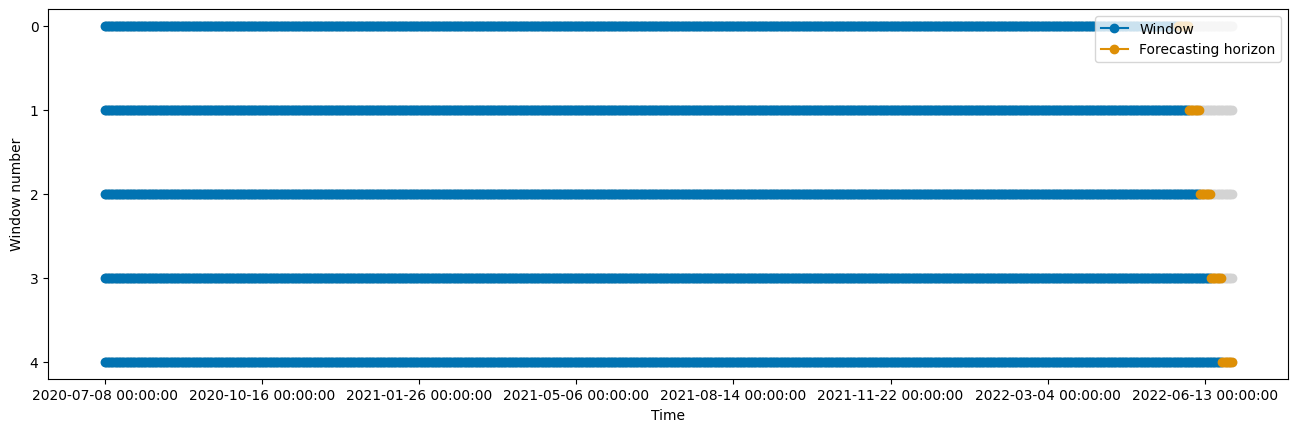

In [ ]:
for i in range(32,33):
    plot_windows(list(cv_list[i][0].values())[0], list(cv_list[i][1].values())[0]["total_amount"])

**Hyperparameter tuning**

Given that CatBoost is a tree-based model, there is a large number of hyperparameters that can be tuned. For this task, the following hyperparameters were chosen:

* Number of trees (estimators)
* Learning rate
* L2 leaf regularization
* Tree depth
* Percentage of datapoint to be used in each tree (bootstrapping)
* Percentage of features to be used in each tree
* Smallest number of data to be used in a leaf before a split is made

In [19]:
def create_train_validation_folds(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_index = df[df.date<first_val_date].index
        val_index = df[(df.date>=first_val_date) & (df.date<=last_val_date)].index
        cv.append((train_index,val_index))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [20]:
x_train = train.reset_index().drop("total_amount", axis = 1)
x_val = val.reset_index().drop("total_amount", axis = 1).set_index("date")
y_train = train.reset_index()[["date","total_amount"]]
y_val = val.reset_index()[["date","total_amount"]].set_index("date")

In [21]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 30),
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "random_strength": trial.suggest_float("random_strength", 1, 10)
    }

    scores = []

    for train_idx, test_idx in create_train_validation_folds(x_train):
        X_train_fold, X_val_fold = x_train.iloc[train_idx], x_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        X_train_fold = X_train_fold.set_index("date")
        X_val_fold = X_val_fold.set_index("date")
        y_train_fold = y_train_fold.set_index("date")
        y_val_fold = y_val_fold.set_index("date")

        model = CatBoostRegressor(**params, loss_function = "RMSE", silent=True,
                                  allow_writing_files = False, task_type="GPU", bootstrap_type="Poisson")

        model.fit(X_train_fold, y_train_fold, eval_set = (x_val, y_val), early_stopping_rounds = 50, cat_features=catfeat)

        y_pred = model.predict(X_val_fold)

        score = mean_squared_error(y_val_fold, y_pred, squared=False)

        scores.append(score)

    return np.mean(scores)

    #cv_scores = cross_val_score(
    #    model,
    #    X_train,
    #    y_train,
    #    scoring='neg_root_mean_squared_error',  # for RMSE
    #    cv=create_train_validation_folds(train.reset_index()),
    #    n_jobs=-1,
    #    error_score = "raise"
    #)

    # Return the mean of the negative RMSE scores, since Optuna maximizes by default
    #return -np.mean(cv_scores)


In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 15)

[I 2024-08-09 12:53:09,751] A new study created in memory with name: no-name-ad675505-d989-4d1d-9418-a75f14091c47
[I 2024-08-09 12:53:35,574] Trial 0 finished with value: 380.6843682879291 and parameters: {'n_estimators': 349, 'learning_rate': 0.0002483207560796887, 'l2_leaf_reg': 4.145919312153844, 'depth': 6, 'subsample': 0.3544059934453484, 'min_data_in_leaf': 22, 'random_strength': 5.035693739511956}. Best is trial 0 with value: 380.6843682879291.
[I 2024-08-09 12:55:04,565] Trial 1 finished with value: 102.13504314288286 and parameters: {'n_estimators': 2793, 'learning_rate': 0.0948724560273695, 'l2_leaf_reg': 20.175788478590995, 'depth': 9, 'subsample': 0.3228633492949712, 'min_data_in_leaf': 93, 'random_strength': 4.688536316741192}. Best is trial 1 with value: 102.13504314288286.
[I 2024-08-09 13:07:17,779] Trial 2 finished with value: 132.9984826286046 and parameters: {'n_estimators': 2486, 'learning_rate': 0.0006600754006910011, 'l2_leaf_reg': 6.140286093816204, 'depth': 9, '

In [23]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 2793, 'learning_rate': 0.0948724560273695, 'l2_leaf_reg': 20.175788478590995, 'depth': 9, 'subsample': 0.3228633492949712, 'min_data_in_leaf': 93, 'random_strength': 4.688536316741192}
Best RMSE: 102.13504314288286


In [36]:
best_parameters = study.best_params
del best_parameters["n_estimators"]

{'learning_rate': 0.0948724560273695,
 'l2_leaf_reg': 20.175788478590995,
 'depth': 9,
 'subsample': 0.3228633492949712,
 'min_data_in_leaf': 93,
 'random_strength': 4.688536316741192}

In [35]:
from google.colab import output
output.enable_custom_widget_manager()

In [40]:
model = CatBoostRegressor(**best_parameters, n_estimators = 3000, allow_writing_files = False)

model.fit(x_train.set_index("date"), y_train.set_index("date"), eval_set=(x_val, y_val),
          early_stopping_rounds = 200, cat_features = catfeat, verbose = 500, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 446.9373173	test: 355.1681387	best: 355.1681387 (0)	total: 12.3ms	remaining: 1m 1s
500:	learn: 86.8800461	test: 100.3005627	best: 99.7705665 (493)	total: 12.5s	remaining: 1m 52s
1000:	learn: 68.6395583	test: 105.1660045	best: 99.6374648 (509)	total: 25.8s	remaining: 1m 43s
1500:	learn: 56.7391306	test: 108.2041452	best: 99.6374648 (509)	total: 39.2s	remaining: 1m 31s
2000:	learn: 48.3776229	test: 111.7797716	best: 99.6374648 (509)	total: 52.5s	remaining: 1m 18s
2500:	learn: 41.9535051	test: 113.5368115	best: 99.6374648 (509)	total: 1m 6s	remaining: 1m 6s
3000:	learn: 36.8712519	test: 114.0517744	best: 99.6374648 (509)	total: 1m 21s	remaining: 54s
3500:	learn: 32.5682725	test: 114.4562559	best: 99.6374648 (509)	total: 1m 35s	remaining: 40.8s
4000:	learn: 29.0753192	test: 114.8224675	best: 99.6374648 (509)	total: 1m 48s	remaining: 27.2s
4500:	learn: 26.0572249	test: 114.8902411	best: 99.6374648 (509)	total: 2m 2s	remaining: 13.6s
4999:	learn: 23.4691964	test: 114.9452364	best: 

### Feature importances

<Axes: xlabel='Feature Id'>

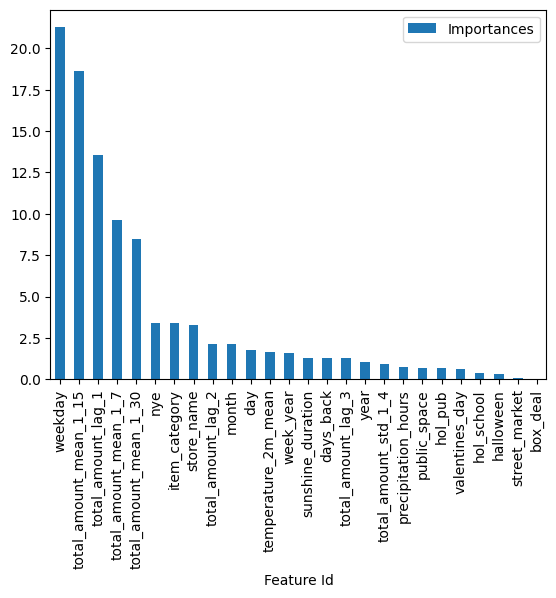

In [41]:
model.get_feature_importance(prettified=True).plot(x = "Feature Id", y = "Importances", kind = "bar")

### Evaluation metrics train and validation set

In [60]:
y_train_pred = model.predict(x_train.set_index("date"))
print(f"R-squared train: {round(r2_score(y_train.set_index('date'), y_train_pred),6)}")
print(f"MAPE train: {round(100*mean_absolute_percentage_error(y_train.set_index('date'), y_train_pred),2)}\n")

y_val_pred = model.predict(x_val)
print(f"R-squared validation: {round(r2_score(y_val, y_val_pred),6)}")
print(f"MAPE validation: {round(100*mean_absolute_percentage_error(y_val, y_val_pred),2)}")

R-squared train: 0.967424
MAPE train: 21.91

R-squared validation: 0.928502
MAPE validation: 30.26


# Test dataset

In [ ]:
x_test_daily_totalamount, y_test_pred =  pred_test(train = train_daily, test = test_daily, model = model, numfeat = numfeat, catfeat = catfeat)

### Residuals by store

In [ ]:
difference_df = diff_overview(data = test_daily, pred = y_test_pred, stores = all)

### Residual Plot Analysis

In [ ]:
sns.scatterplot(data = difference_df, x = "Predicted", y = "Stand_resid")

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales (Daily total)")
plt.ylabel("Standardized Residuals")

plt.show()

### Evaluation metrics train and test set

In [ ]:
fit_overview(ytrain = y_train_daily, ytrainpred = y_train_pred, ytest = y_test_daily, ytestpred = y_test_pred)

In [ ]:
mape_stores(test_daily, y_test_pred)

### Visualisation of predictions

In [ ]:
df_predicted = pd.concat(
    [
    difference_df[["Date","Store name","Observed","Predicted"]].rename(columns = {"Date":"date","Store name":"store_name","Observed":"total_amount"}),
    d[(d["date"] >= pd.to_datetime("2024-05-01")) & (d["item_category"] == "daily total")][["date","store_name","total_amount"]]
    ]
    )

In [ ]:
ts_predicted(df_predicted)

In [ ]:
def create_train_validation_dataset(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_fold = df[df.date<first_val_date]
        val_fold = df[(df.date>=first_val_date) & (df.date<=last_val_date)]
        cv.append((train_fold,val_fold))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
for i in range(5):
  globals()[f"train_{i}"], globals()[f"val_{i}"] = create_train_validation_dataset(train_daily)[i]